In [1]:
!rm -rf /kaggle/working/*

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.preprocessing import image


In [3]:
img_shape = (224,224)
BATCH_SIZE = 32

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.1,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

val_test_datagen = ImageDataGenerator(
rescale = 1./255)



train_data_gen = train_datagen.flow_from_directory(
'/kaggle/input/teeth-dataset1/Teeth_Dataset/Training',
target_size = img_shape,
batch_size = BATCH_SIZE,
class_mode = 'categorical')

val_data_gen = val_test_datagen.flow_from_directory(
'/kaggle/input/teeth-dataset1/Teeth_Dataset/Validation',
target_size = img_shape,
batch_size = BATCH_SIZE,
class_mode = 'categorical')

test_data_gen = val_test_datagen.flow_from_directory(
    directory='/kaggle/input/teeth-dataset1/Teeth_Dataset/Testing',

    target_size = img_shape,
    batch_size = BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to set shuffle=False for a correct confusion matrix
)


# Verify class labels
print("train class indices:", train_data_gen.class_indices)

print("validation class indices:", val_data_gen.class_indices)

print("test class indices:", test_data_gen.class_indices)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
train class indices: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
validation class indices: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
test class indices: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


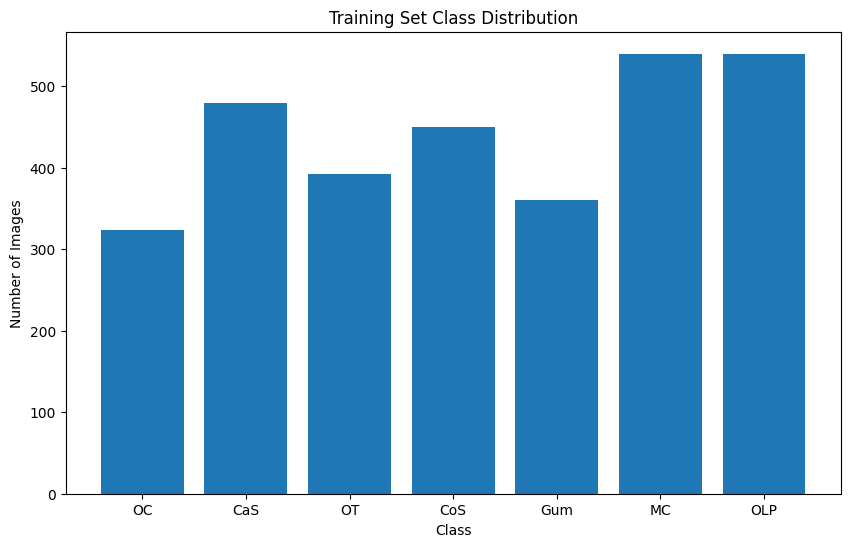

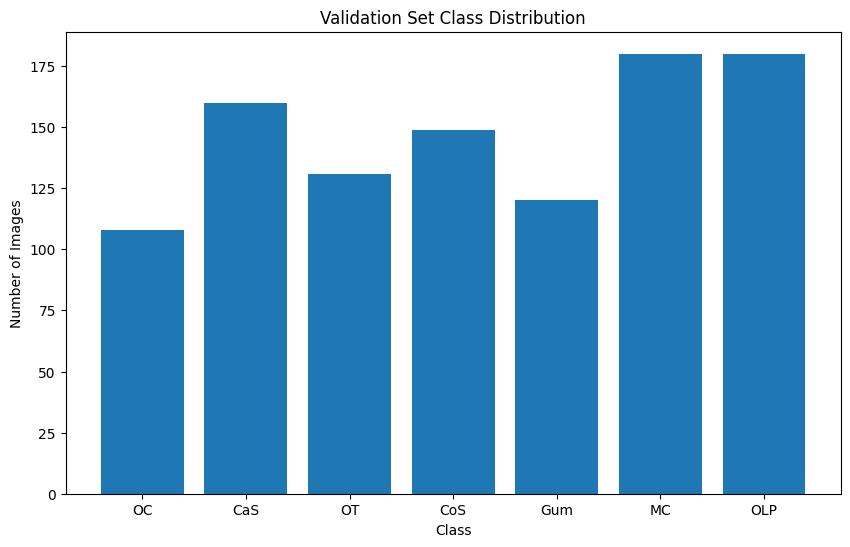

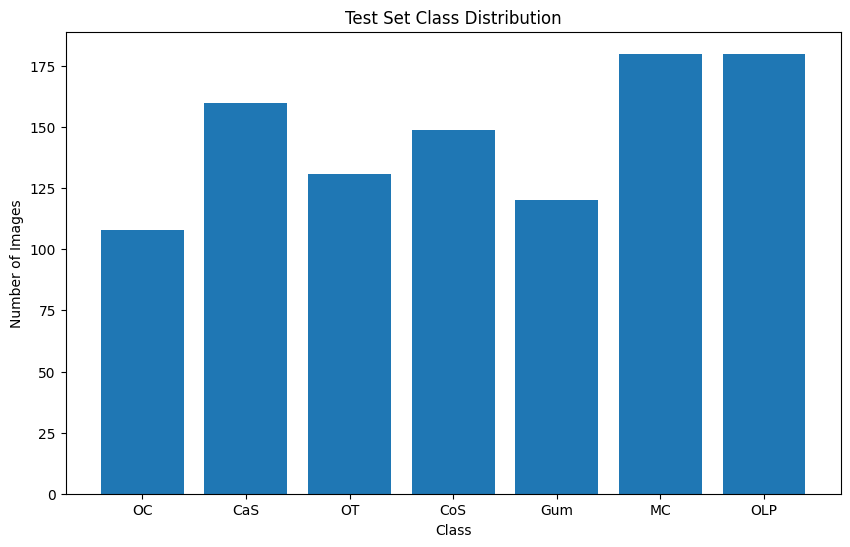

In [5]:
#### Visualizing every class distribution ##########
def count_images(directory):
    class_counts = Counter()
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Count images in each set
train_class_counts = count_images('/kaggle/input/teeth-dataset1/Teeth_Dataset/Training')
val_class_counts = count_images('/kaggle/input/teeth-dataset1/Teeth_Dataset/Validation')
test_class_counts = count_images('/kaggle/input/teeth-dataset1/Teeth_Dataset/Testing')

# Plot class distribution
def plot_class_distribution(counts, title):
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.show()

plot_class_distribution(train_class_counts, 'Training Set Class Distribution')
plot_class_distribution(val_class_counts, 'Validation Set Class Distribution')
plot_class_distribution(test_class_counts, 'Test Set Class Distribution')

Original Image array range: 0.0 255.0
Original Image array dtype: float32


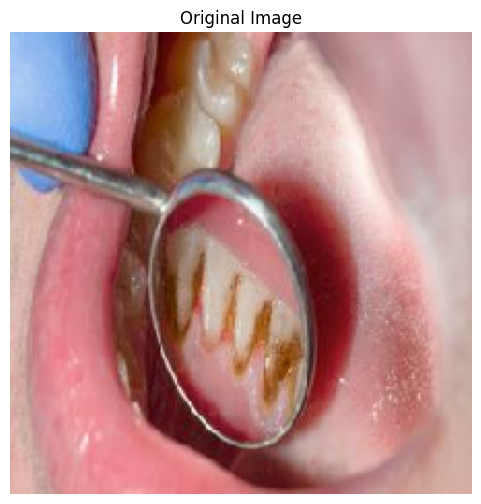

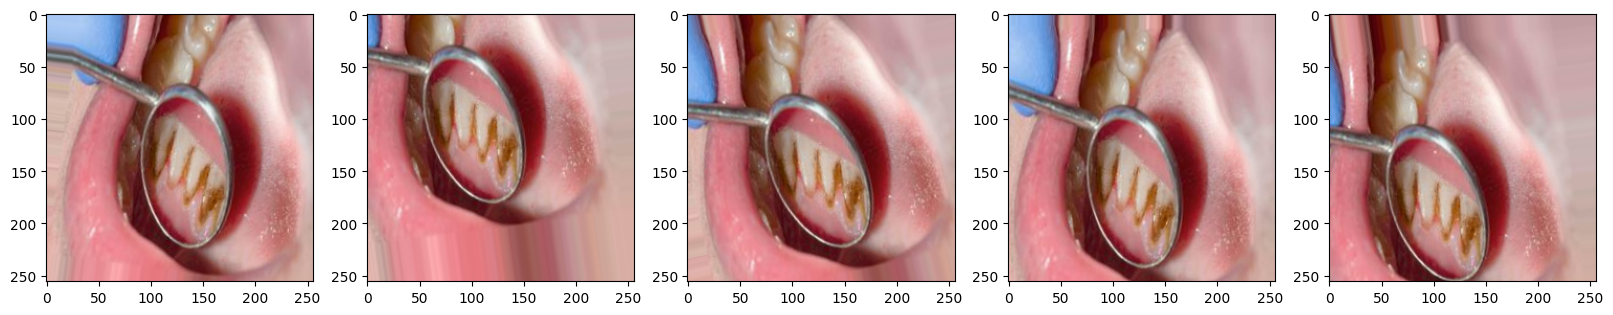

In [6]:
### Visualizing an original and augmented image

# Load a sample image from the training set
sample_image_path = '/kaggle/input/teeth-dataset1/Teeth_Dataset/Testing/Gum/g_1202.jpg' 
sample_image = load_img(sample_image_path, target_size=img_shape)
sample_image_array = img_to_array(sample_image)
sample_image_array = np.expand_dims(sample_image_array, axis=0)

# Check the range and type of the original image array
print("Original Image array range:", sample_image_array.min(), sample_image_array.max())
print("Original Image array dtype:", sample_image_array.dtype)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(sample_image_array[0] / 255.0)  # Rescale to [0, 1] range for displaying
plt.title('Original Image')
plt.axis('off')
plt.show()

def visualize_augmentation(datagen, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    fig, ax = plt.subplots(1, 5, figsize=(20, 20))
    for batch in datagen.flow(x, batch_size=1):
        ax[i].imshow(tf.keras.preprocessing.image.array_to_img(batch[0]))
        i += 1
        if i % 5 == 0:
            break
    plt.show()

# Set image path
image_path = "/kaggle/input/teeth-dataset1/Teeth_Dataset/Testing/Gum/g_1202.jpg"

# Visualize augmented images
visualize_augmentation(train_datagen, sample_image_path)

In [7]:
# Assigning weights to the data to reduce the effect of the imbalancing in the data

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data_gen.classes), y=train_data_gen.classes)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights: ", class_weights_dict)

Class Weights:  {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [8]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights = 'imagenet',input_shape = (224,224,3),include_top = False)


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512 , activation = 'relu')(x)
num_classes = 7
predictions = Dense(num_classes, activation='softmax')(x)
# Configure the model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,917,447 (11.13 MB)

 Trainable params: 659,463 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy',metrics=METRICS)

In [13]:
from keras.callbacks import ModelCheckpoint
# Create a callback that saves the model's weights
checkpoint = ModelCheckpoint(
    filepath='model_checkpoint.keras',  # File path where the model will be saved
    monitor='val_loss',  # Metric to monitor
    verbose=1,  # Verbosity mode, 1 will print messages when saving the model
    save_best_only=True,  # Save only the best model according to the monitored metric
    mode='min'  # Mode for the monitored metric, 'min' to save when it decreases
)

In [14]:
#implement Early stopping
from keras.callbacks import  EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [15]:
# trying different learning rates 
from keras.callbacks import  ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.0000000001
)

In [16]:
history = model.fit(
    train_data_gen,
    epochs=120,
    validation_data=val_data_gen,
    class_weight=class_weights_dict,
    callbacks = [checkpoint, early_stopping, reduce_lr]
)

Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724599176.399296    1235 service.cc:145] XLA service 0x7c72f0003a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724599176.399367    1235 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724599176.399372    1235 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/97 ━━━━━━━━━━━━━━━━━━━━ 20:47 13s/step - accuracy: 0.1562 - loss: 2.2600 - precision: 0.1111 - recall: 0.0312

I0000 00:00:1724599181.492834    1235 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3503 - loss: 6.3765 - precision: 0.4132 - recall: 0.2153
Epoch 1: val_loss improved from inf to 0.92629, saving model to model_checkpoint.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 462ms/step - accuracy: 0.3528 - loss: 6.3034 - precision: 0.4169 - recall: 0.2172 - val_accuracy: 0.6595 - val_loss: 0.9263 - val_precision: 0.7624 - val_recall: 0.5243 - learning_rate: 0.0100
Epoch 2/120
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6612 - loss: 0.8590 - precision: 0.7612 - recall: 0.5575
Epoch 2: val_loss improved from 0.92629 to 0.56213, saving model to model_checkpoint.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 344ms/step - accuracy: 0.6621 - loss: 0.8571 - precision: 0.7617 - recall: 0.5589 - val_accuracy: 0.7977 - val_loss: 0.5621 - val_precision: 0.8663 - val_recall: 0.7247 - learning_rate: 0.0100
Epoch 3/120
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7779 - loss: 0.5811 - precision: 0.8386 - recall: 0.7042
Epoch 3: val_l

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9895 - loss: 0.0357 - precision: 0.9899 - recall: 0.9875
Test loss: 0.05939062312245369
Test accuracy: 97.85992503166199%
Test precsion: 0.98046875
Test recall: 0.9766536951065063
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


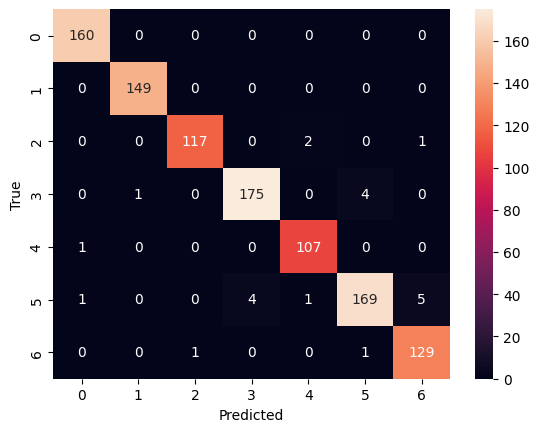

In [24]:
# Evaluate the Model

results = model.evaluate(test_data_gen)
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]*100}%")
print(f"Test precsion: {results[2]}")
print(f"Test recall: {results[3]}")



# Predict the values from the test dataset
Y_pred = model.predict(test_data_gen)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert test data to one hot vectors
Y_true = test_data_gen.classes
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
# classification report for each class

from sklearn.metrics import classification_report

report = classification_report(Y_true, Y_pred_classes, target_names=['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'])
print(report)

              precision    recall  f1-score   support

         CaS       0.99      1.00      0.99       160
         CoS       0.99      1.00      1.00       149
         Gum       0.99      0.97      0.98       120
          MC       0.98      0.97      0.97       180
          OC       0.97      0.99      0.98       108
         OLP       0.97      0.94      0.95       180
          OT       0.96      0.98      0.97       131

    accuracy                           0.98      1028
   macro avg       0.98      0.98      0.98      1028
weighted avg       0.98      0.98      0.98      1028

